# Some examples of lenstool usage on Jupyter Notebook

## The SIS model (Singular Isothermal Sphere)
In this notebook we will showcase lensing modelling with Lenstool using the SIS model.

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.table import Table
from matplotlib.patches import Ellipse
from matplotlib.patches import Circle
import os
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy
import lenstool
from lenstool.potentials import sis
lenstool.__version__

'8.6.1'

In [2]:
lt = lenstool.Lenstool()
lt.add_lens(sis(0.,0.,0.3,800))
lt.set_cosmology(70, 0.3, 0.7, -1)
lt.set_field(50)
lt.set_grid(1000, 1)

## The inputs

We will first define the lens model. In this example, the lens is a single SIS potential. It is centered at (0,0) and has a redshift of 0.3.


In [3]:
lt.get_lenses()

<Table length=1>
 type  n      x       y       z   
int64 str1 float64 float64 float64
----- ---- ------- ------- -------
    1    1     0.0     0.0     0.3

## The source definition
The source properties are coordinates in arcsec, size, redshift, orientation angle and magnitude (brightness).
These parameters must be given directly in the code .
Here we study a circular source of redshift 1 and magnitude 20. 

In [6]:
tab = Table(names=['n','x','y','a','b','theta','z','mag'], dtype=['str',*['float',]*7])
tab.add_row(['1a', 0.6789067, -9.7, 3.5, 3.5, 0, 1.0, 20])
tab.meta['iref'], tab.meta['ref_ra'], tab.meta['ref_dec'] = 3, 0, 0
lt.set_sources(tab)
lt.get_sources()

<Table length=1>
 n       x        y       a       b     theta     z      mag  
str2  float64  float64 float64 float64 float64 float64 float64
---- --------- ------- ------- ------- ------- ------- -------
  1a 0.6789067    -9.7     3.5     3.5     0.0     1.0    20.0

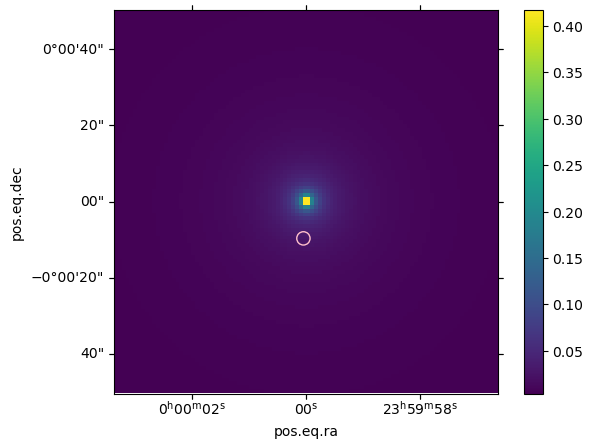

In [7]:
mass, wcs = lt.g_mass(3, 100, 0.3, 1.0)

fig = plt.figure()
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=wcs)
plt.imshow(mass)
plt.colorbar()

for row in lt.get_sources(): 
    ellipse = Ellipse((row['x']/3600.,row['y']/3600.), #conversion from arcsecs to degrees
                      width=row['b']/3600, 
                      height=row['a']/3600,
                      edgecolor='pink',
                      facecolor='none',
                      angle =row['theta']+90,
                      transform=plt.gca().get_transform('world')
                     )
 
    ax.add_patch(ellipse)

Here we have displayed the source in pink and the cluster of galaxies that acts as a lens in yellow.
The colorbar indicates the mass repartition of the cluster in $10^{12}$ Msun/pixel.

## Modelling gravitational lensing
Using the data from the above source, one or more images can be created corresponding to the gravitational lensing under study.

In [8]:
lt.e_lensing()
lt.get_images()

<Table length=3>
 n            x                   y          ...    z           mag       
str2       float64             float64       ... float64      float64     
---- -------------------- ------------------ ... ------- -----------------
  1a -0.14390360326579424  2.056015418854247 ...     1.0 21.68436369398107
  1a -0.14387454674727249  2.057052271183966 ...     1.0 21.68370475741009
  1a   1.5017408667543073 -21.45605858938671 ...     1.0 19.13805902100179

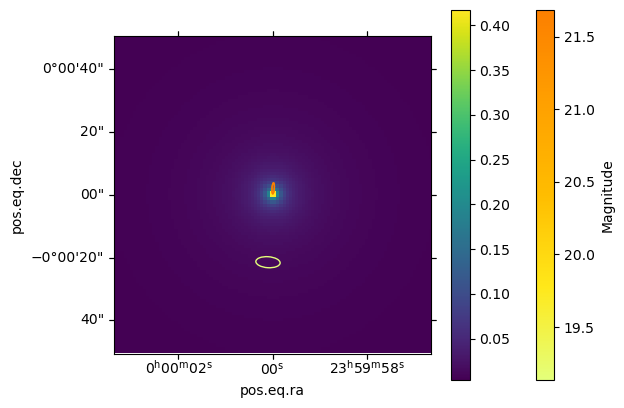

In [9]:
def plot_images():
    fig = plt.figure()
    ax = fig.add_subplot(projection=wcs)
    plt.imshow(mass)

    norm = Normalize(min(lt.get_images()['mag']), max(lt.get_images()['mag']))
    for row in lt.get_images(): 
        ellipse = Ellipse((row['x']/3600.,row['y']/3600.),
                          width=row['b']/3600,
                          height=row['a']/3600,
                          facecolor = 'none',
                          angle =row['theta'] + 90,
                          transform=plt.gca().get_transform('world')
                         )
         # Assign color to the ellipse based on the magnification

        color = cm.ScalarMappable(norm=norm, cmap = 'Wistia').to_rgba(row['mag'])
        ellipse.set_edgecolor(color)

        ax.add_patch(ellipse)

    # Creating a ScalarMappable object for colorbar
    cmap = cm.ScalarMappable(norm=norm, cmap = 'Wistia')
    cmap.set_array(tab['mag'])

    # Adding the colorbar
    colorbar = plt.colorbar(cmap, ax=ax)
    colorbar.set_label('Magnitude')
    plt.colorbar()
    plt.show()
plot_images()

As we can see, three images are displayed whereas in the SIS model only two images should appear. This happens because due to numerical resolution limits, Lenstool finds two radial images, whereas only one should exist in theory. Note that depending on the grid.number, and grid.polar parameters, this third image is not always detected.

### With another source

In [12]:
tab = Table(
    rows=[('1a', 10.6789067, 10.7, 3.5, 3.5, 0, 1.0, 20)],
    names=['n','x','y','a','b','theta','z','mag'], 
    dtype=['str',*['float',]*7]
)
tab.meta['iref'], tab.meta['ref_ra'], tab.meta['ref_dec'] = 3, 0, 0
lt.set_sources(tab)
lt.get_sources()

<Table length=1>
 n       x         y       a       b     theta     z      mag  
str2  float64   float64 float64 float64 float64 float64 float64
---- ---------- ------- ------- ------- ------- ------- -------
  1a 10.6789067    10.7     3.5     3.5     0.0     1.0    20.0

In [13]:
lt.e_lensing()
display(lt.get_images())

<Table length=1>
 n           x                  y          ...    z           mag        
str2      float64            float64       ... float64      float64      
---- ------------------ ------------------ ... ------- ------------------
  1a 19.003780153858134 19.041315591211987 ...     1.0 19.374217246134503

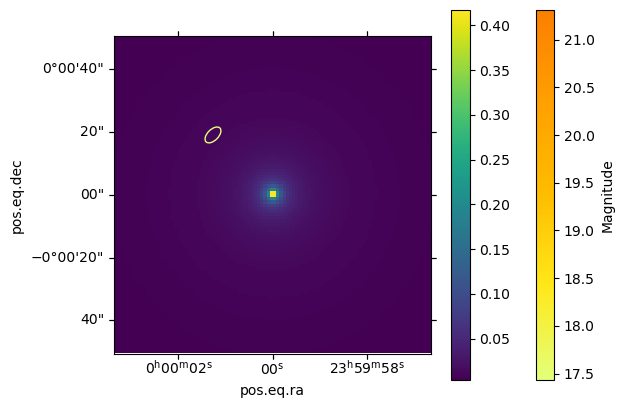

In [14]:
plot_images()

In [16]:
tab = Table(
    rows=[('1a', 1.7, 1.7, 3.5, 3.5, 0, 1.0, 20)],
    names=['n','x','y','a','b','theta','z','mag'], 
    dtype=['str',*['float',]*7]
)
tab.meta['iref'], tab.meta['ref_ra'], tab.meta['ref_dec'] = 3, 0, 0
lt.set_sources(tab)
lt.get_sources()

<Table length=1>
 n      x       y       a       b     theta     z      mag  
str2 float64 float64 float64 float64 float64 float64 float64
---- ------- ------- ------- ------- ------- ------- -------
  1a     1.7     1.7     3.5     3.5     0.0     1.0    20.0

In [17]:
lt.e_lensing()
display(lt.get_images())

<Table length=2>
 n           x                  y          ...    z           mag        
str2      float64            float64       ... float64      float64      
---- ------------------ ------------------ ... ------- ------------------
  1a  10.03309421074721  10.03309421074721 ...     1.0  18.07253367121692
  1a -6.633066375294565 -6.633066375294565 ...     1.0 18.521855628870078

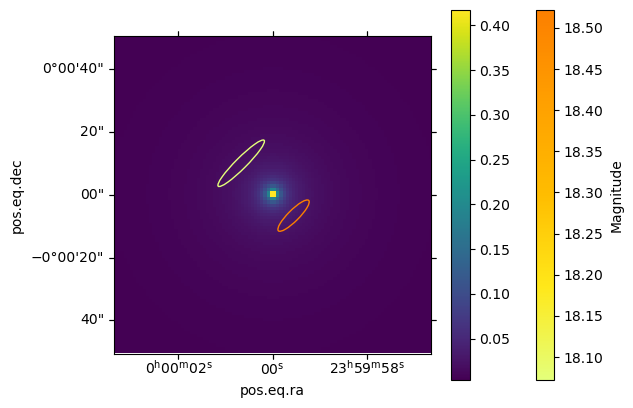

In [18]:
plot_images()

By moving the source closer to the lens, the flux can be amplified.
The second colorbar represents the magnitude values of the obtained images. 

In [19]:
tab = Table(
    rows=[('1a', 0.6789067, -9.7, 5.5, 5.5, 0, 1.5, 20)],
    names=['n','x','y','a','b','theta','z','mag'], 
    dtype=['str',*['float',]*7]
)
tab.meta['iref'], tab.meta['ref_ra'], tab.meta['ref_dec'] = 3, 0, 0
lt.set_sources(tab)
lt.get_sources()

<Table length=1>
 n       x        y       a       b     theta     z      mag  
str2  float64  float64 float64 float64 float64 float64 float64
---- --------- ------- ------- ------- ------- ------- -------
  1a 0.6789067    -9.7     5.5     5.5     0.0     1.5    20.0

In [20]:
lt.e_lensing()
display(lt.get_images())

<Table length=2>
 n            x                    y          ...    z           mag        
str2       float64              float64       ... float64      float64      
---- -------------------- ------------------- ... ------- ------------------
  1a -0.25707791557222887  3.6729549940005506 ...     1.5 21.054388909410587
  1a   1.6149036200952658 -23.072957535127333 ...     1.5 19.059172764025583

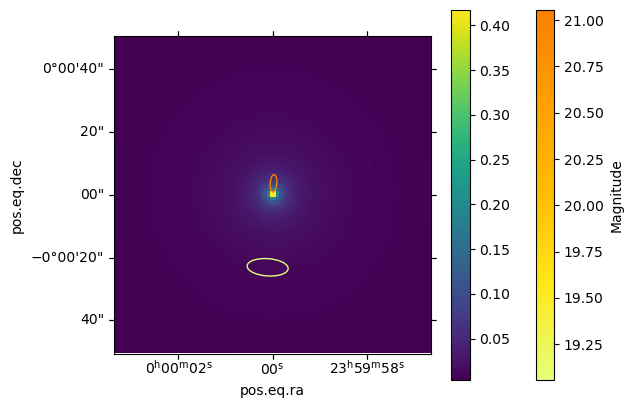

In [21]:
plot_images()

The image obtained for the first source studied is modelled again and the size of the source is increased; it can be seen that the size of the image is also increased.  

In [22]:
tab = Table(
    rows=[('1a', 0.6789067, -9.7, 3.5, 3.5, 0, 15.0, 20)],
    names=['n','x','y','a','b','theta','z','mag'], 
    dtype=['str',*['float',]*7]
)
tab.meta['iref'], tab.meta['ref_ra'], tab.meta['ref_dec'] = 3, 0, 0
lt.set_sources(tab)
lt.get_sources()

<Table length=1>
 n       x        y       a       b     theta     z      mag  
str2  float64  float64 float64 float64 float64 float64 float64
---- --------- ------- ------- ------- ------- ------- -------
  1a 0.6789067    -9.7     3.5     3.5     0.0    15.0    20.0

In [23]:
lt.e_lensing()
display(lt.get_images())

<Table length=2>
 n            x                   y          ...    z           mag       
str2       float64             float64       ... float64      float64     
---- ------------------- ------------------- ... ------- -----------------
  1a  1.8173670426662394 -25.965958656690344 ...    15.0 18.93091728652996
  1a -0.4595568468859493   6.565971489067192 ...    15.0 20.42368152225295

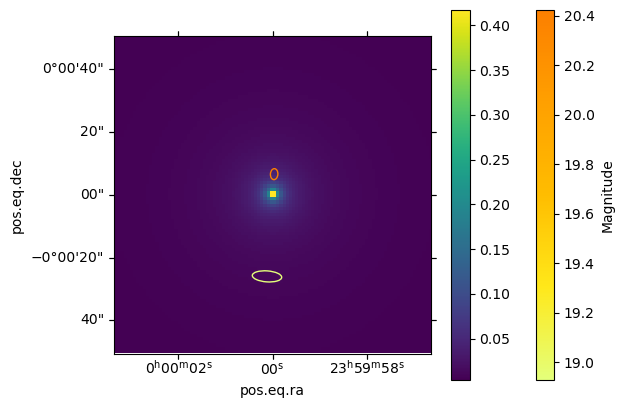

In [24]:
plot_images()

When the redshift is increased, the distance between the images is also increased. 

In [25]:
tab = Table(
    rows=[('1a', 0.3789067, 0.4, 3.5, 3.5, 0, 1.0, 20)],
    names=['n','x','y','a','b','theta','z','mag'], 
    dtype=['str',*['float',]*7]
)
tab.meta['iref'], tab.meta['ref_ra'], tab.meta['ref_dec'] = 3, 0, 0
lt.set_sources(tab)
lt.get_sources()

<Table length=1>
 n       x        y       a       b     theta     z      mag  
str2  float64  float64 float64 float64 float64 float64 float64
---- --------- ------- ------- ------- ------- ------- -------
  1a 0.3789067     0.4     3.5     3.5     0.0     1.0    20.0

In [26]:
lt.e_lensing()
display(lt.get_images())

<Table length=2>
 n           x                  y          ...    z           mag       
str2      float64            float64       ... float64      float64     
---- ------------------ ------------------ ... ------- -----------------
  1a  8.483351108269728  8.955704565242334 ...     1.0  16.6249986762484
  1a -7.725506849912627 -8.155647694845774 ...     1.0 16.72653882184898

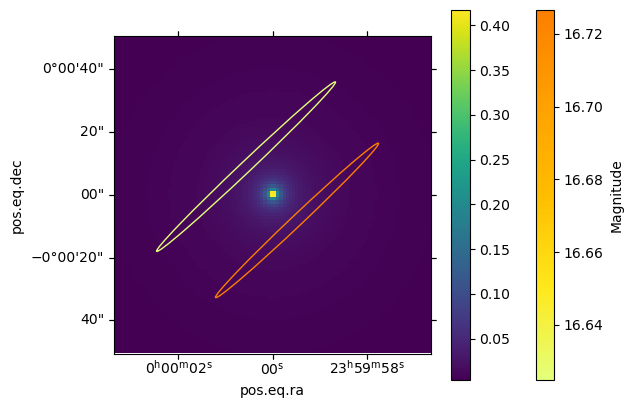

In [27]:
plot_images()

By moving the source closer to the lens again, the images appear streched.

## Modelling of the Einstein ring
Now that we have seen the impact of each parameter on the resulting image, we want to model the Einstein ring.
To do so we can model the brightness map with lenstool.

Text(0.5, 1.0, 'Source plane')

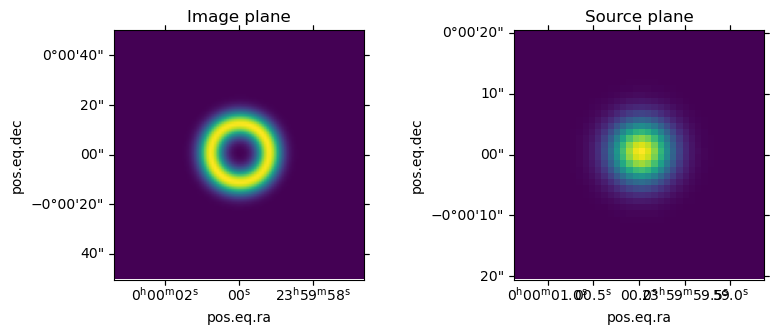

In [28]:
pix, wcs = lt.e_pixel_image(100)
source, swcs = lt.e_pixel_source(100)
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.15, 0.1, 0.5, 0.5], projection=wcs)

plt.imshow(pix)

ax.autoscale_view()
ax.set_title('Image plane')

ax = fig.add_axes([0.55, 0.1, 0.5, 0.5], projection=swcs)

plt.imshow(source)
ax.autoscale_view()
ax.set_title('Source plane')

## The convergence map

Lenstool can also compute the convergence map of the lens.


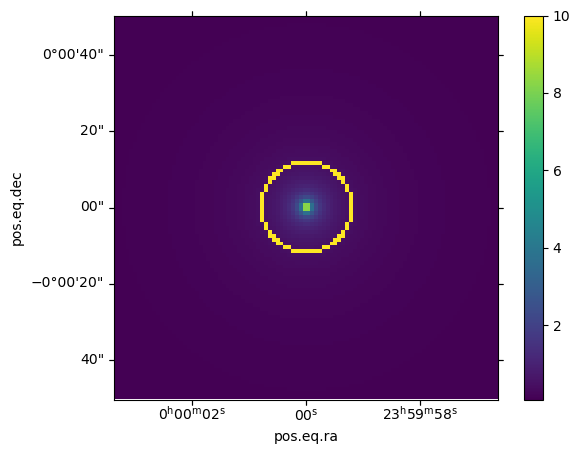

In [29]:
conv, wcs = lt.g_mass(1, 100, 0.3, 1.0)

fig = plt.figure()
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=wcs)

s = abs(conv - 1/2) < 0.02
conv[s] = 10
plt.imshow(conv)
plt.colorbar()

Here, the yellow circle is the critical line for our SIS model (when the convergence = 1/2).

## Calculation of the Einstein ring
We start by using the lensing equations to obtain the radius of the ring created by gravitational lensing. <br>
$$\theta_{E} = \frac{4 \pi\sigma_{v}^{2}}{c^{2}}\frac{D_{LS}}{D_{S}} $$

We can calculate the distances to the source and to the lens with the redshift data.

In [30]:
from math import pi
import astropy.constants as const
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

cosmo= FlatLambdaCDM(70,0.3)                     # definition of the universe (H0, z_lens)
dol=cosmo.angular_diameter_distance(0.3)         # distance between the observer and the lens
dos=cosmo.angular_diameter_distance(1)           # distance between the observer and the source
dls=cosmo.angular_diameter_distance_z1z2(0.3,1)  # distance between the lens and the source
sigma = 800 * u.km /u.s
theta = (4*pi*sigma**2*dls)/(dos*const.c**2)
theta = theta.to('m2/m2').value
print("the radius value is:",theta)                                  

the radius value is: 5.713423457351448e-05


Now that we have the radius we can display the ring.<br>
To observe the match with the magnification map, it is also possible to directly display the ring on it. 

Text(0.5, 1.0, 'Magnification map')

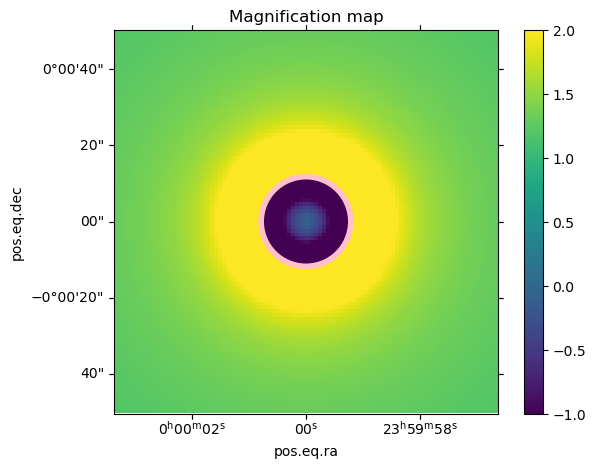

In [31]:
ampli, wcs = lt.g_ampli(1, 100, 1.0)

fig = plt.figure()
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=wcs)

plt.imshow(ampli)
plt.clim((-1,2))
plt.colorbar()

c = Circle((0,0),
           numpy.degrees(theta),
           edgecolor='pink',
           facecolor='none',
           linewidth=4,
           transform=ax.get_transform('world')
          )
           
        
ax.add_patch(c)
ax.set_title('Magnification map')

Here the Eistein ring is pink and the colorbar indicates the magnification factor.

## Display of critical lines
Another method to represent the critical lines is to use the data calculated by Lenstool, we can then also represent the caustic lines.

COMP1: critic and caustic lines for source plane at z=1.000
limitHigh(in arcsec)=10.000 limitLow(in arcsec)=1.000
xmin=-50.0 ymin=-50.0 xmax=50.0 ymax=50.0


Text(0.5, 1.0, 'Source plane')

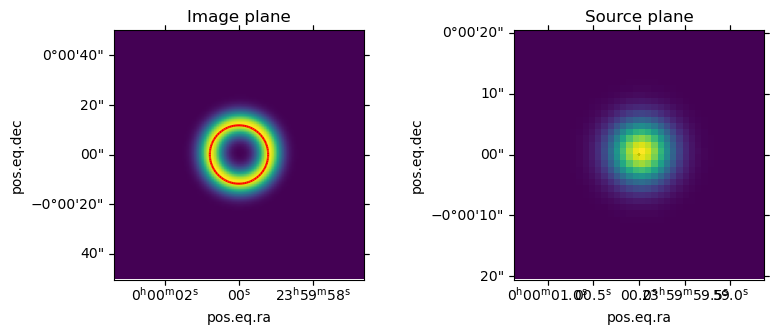

In [33]:
from lenstool import plot

# Compute image plane and source plane surface brightness maps
pix, wcs = lt.e_pixel_image(100)
source, swcs = lt.e_pixel_source(100)

# Compute critical and caustic external lines
tangent, radial = lt.criticnew(1.0)
critic_int, caustic_int = plot.parse_cline(radial)

fig = plt.figure(figsize=(10,5))

ax = fig.add_axes([0.15, 0.1, 0.5, 0.5], projection=wcs)
plt.imshow(pix)
critic_int.set_transform(ax.get_transform('world'))
ax.add_collection(critic_int)
ax.autoscale_view()
ax.set_title('Image plane')

ax = fig.add_axes([0.55, 0.1, 0.5, 0.5], projection=swcs)
plt.imshow(source)
caustic_int.set_transform(ax.get_transform('world'))
ax.add_collection(caustic_int)
ax.autoscale_view()
ax.set_title('Source plane')

Here we display the external critical and caustic lines of the lens.<br>
In the image plane, the critical line is a circle (as we calculated) superposed to the Einstein ring whereas the caustic line in the source plane is a point centered on the source.<br>
If we were to model the internal lines, it would be the opposite, meaning that the internal critical line would be a point in the image plane and the caustic line a circle in the source plane. However, this point in the image plane is infinitely small, and Lenstool cannot find it, hence it cannot compute the associated caustic line.